In [1]:
from correlations import Correlation, Variable
from correlations import load_data_for_correlation
from pathlib import Path
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from tools import *
from matplotlib.colors import LogNorm, Normalize
import matplotlib.cm as cm

# Largeurs de la corrélation

Ce code permet de produire différentes figures afin de mettre en valeur la corrélation sur z. Pour fonctionner, il a besoin de la classe Correlation et Variable, définies dans le fichier correlations.py ainsi que divers outils définis dans tools.py.

La variable "save" permet de sauver les scripts utilisé et de sauvegarder l'ensemble de la séquence. Cela a de la pertinence lorsuq'on utilise le script main.py : dans le notebook, save est toujours réglé à False.



## Choix du jeu de données

In [2]:
path = Path("E:/2022/05/24")
jeu_donnees = "13mai.pkl"
save = False # est-ce que on sauvegarde les données
data = pd.read_pickle(os.path.join(path, jeu_donnees))
# data = data[data["Cycle"] < 50]
n_cycles = int(np.max(data["Cycle"]))

In [193]:
################ Définition des fonctions d'affichage : toutes les variables sont globales car flemme.
def plot_all_densities():
    print("#################################################")
    print("#### Please chose your box scan below this  ####")
    print("####  cell once you are sure of their size  ####")
    print("#################################################")
    hist = corr.show_density(nameX="Vy", nameY="Vz", show_plot=True)
    hist = corr.show_density(nameX="Vx", nameY="Vz", show_plot=True)
    hist = corr.show_density(nameX="Vx", nameY="Vy", show_plot=True)
def show_second_serie_plots():
    ####################################################
    ############### AFFICHAGE #############
    ####################################################
    print("##############################################################")
    print("#  Please chose your new Roi for   ")
    print("####Plot_var = {}  and Int_var = {}".format(Plot_var, Int_var))
    print("#################################################")
    # ----------------------------------------------------------------------
    # Corrélation croisée : density plot 2D de g^2
    # ----------------------------------------------------------------------
    x = corr.var1.name
    y = corr.var2.name
    z = "g^2"
    df_pivoted_correlations = corr.result.pivot(index=x, columns=y, values=z)
    fig, ax = plt.subplots()
    sns.heatmap(
        df_pivoted_correlations,
        cmap="YlGnBu",
        ax=ax,
        # norm=LogNorm()
        vmin=gmin_value,
        vmax=gmax_value,
    )
    ax.invert_yaxis()
    # On dessine des boites pour représenter les boites de corrélation
    def draw_box(cX, σX, cY, σY, color="orange", label="boite"):
        plt.plot(
            [cX - σX, cX + σX, cX + σX, cX - σX, cX - σX],
            [cY - σY, cY - σY, cY + σY, cY + σY, cY - σY],
            color,
        )

    zz1 = np.argmin(np.abs(corr.var1.values - boxes[corr.var1.box][corr.var1.axe]["position"]))
    zz2 = np.argmin(np.abs(corr.var2.values - boxes[corr.var2.box][corr.var2.axe]["position"]))
    box_size1 = corr.boxes[corr.var1.box][corr.var1.axe]["size"] / corr.var1.step / 2
    box_size2 = corr.boxes[corr.var2.box][corr.var2.axe]["size"] / corr.var2.step / 2
    draw_box(zz2, box_size2, zz1, box_size1)
    box_size1 = 3 * box_size1
    box_size2 = 3 * box_size2
    draw_box(zz2, box_size2, zz1, box_size1, color="darkred")
    plt.title(z+" dans la zone scanée par les variables.")
    if save == True:
        print("saving")
        image_name = get_image_name(seq_folder, seq_num)
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.clf()
        plt.close()
    else:
        plt.show()

    # ----------------------------------------------------------------------
    # Nombre d'atomes dans la boite 1 et 2 le long de ses variations.
    # ----------------------------------------------------------------------
    plt.figure()
    small_df = corr.result[corr.result[corr.var2.name] == corr.var2.min]
    z = "N_1"
    maximum_position = np.argmax(small_df[z])
    box_size = corr.boxes[corr.var1.box][corr.var1.axe]["size"]
    box_volume = corr.boxes[corr.var1.box]["Vx"]["size"] * corr.boxes[corr.var1.box]["Vy"]["size"] * corr.boxes[corr.var1.box]["Vz"]["size"]
    plt.errorbar(
        small_df[corr.var1.name] -small_df[corr.var1.name].to_numpy()[maximum_position], small_df[z]/box_volume, yerr=small_df[z + " error"]/box_volume, fmt="o",
        label = z+" among "+corr.var1.name
        
    )
    small_df = corr.result[corr.result[corr.var1.name] == corr.var1.min]
    z = "N_2"
    box_size = corr.boxes[corr.var2.box][corr.var2.axe]["size"]
    maximum_position = np.argmax(small_df[z])
    box_volume = corr.boxes[corr.var2.box]["Vx"]["size"] * corr.boxes[corr.var2.box]["Vy"]["size"] * corr.boxes[corr.var2.box]["Vz"]["size"]
    plt.errorbar(
        small_df[corr.var2.name] -small_df[corr.var2.name].to_numpy()[maximum_position] , small_df[z]/box_volume, yerr=small_df[z + " error"]/box_volume, fmt="o",
        label = z+" among "+corr.var2.name
    )
    plt.legend()
    plt.title("Density profile along the 1st box scan Δ{} = {} mm/s".format(corr.var1.name,box_size ))
    plt.ylabel("Densisity ( at / (mm/s)$\mathregular{^3}$ )")
    plt.xlabel("Ecart au maximum de densite {} (mm/s)".format(corr.var1.axe))
    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.clf()
        plt.close()
    else:
        plt.show()
    # ----------------------------------------------------------------------
    # Corrélation croisée : density plot 2D de g^2 à 45°
    # ----------------------------------------------------------------------

    z = "g^2"
    df_pivoted_correlations = corr.result.pivot(index=Int_var, columns=Plot_var, values=z)
    df_pivoted_correlations = df_pivoted_correlations.interpolate()
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(
        df_pivoted_correlations,
        cmap="YlGnBu",
        ax=ax,
        vmin=gmin_value,
        vmax=gmax_value,
    )
    ax.invert_yaxis()
    plt.title(f"{z} tourné dans l'espace scanné par les variables.")
    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.close()
    else:
        plt.show()
        
def show_third_serie_of_plots():    
    ####################################################
    ############# NOUVELLE ROI ET AFFICHAGE ############
    ####################################################
    # ----------------------------------------------------------------------
    # Density plot 2D de g^2 dans la nouvelle zone d'intérêt
    # ----------------------------------------------------------------------
    z = "g^2"
    df_pivoted_correlations = df.pivot(index=Int_var, columns=Plot_var, values=z)
    df_pivoted_correlations = df_pivoted_correlations.interpolate()
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(
        df_pivoted_correlations,
        cmap="YlGnBu",
        ax=ax,
        vmin=gmin_value,
        vmax=gmax_value,
    )
    plt.title(f"{z} dans la zone d'intérêt tournée à 45°.")
    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.close()
    else:
        plt.show()

    # ----------------------------------------------------------------------
    # Density plot 2D de la population
    # ----------------------------------------------------------------------
    z = "N_1+N_2"
    df_pivoted_correlations = df.pivot(index=Int_var, columns=Plot_var, values=z)
    df_pivoted_correlations = df_pivoted_correlations.interpolate()
    fig, ax = plt.subplots()
    sns.heatmap(
        df_pivoted_correlations,
        cmap="YlGnBu",
        ax=ax,
        # norm=LogNorm()
    )
    plt.title(f"{z} dans la nouvelle zone d'intérêt.")
    ax.invert_yaxis()
    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.close()
    else:
        plt.show()

    # ----------------------------------------------------------------------
    # G^2 : plot 1D fouilli avec colormap pour population
    # ----------------------------------------------------------------------
    df.plot.scatter(x=Plot_var, y="g^2", c="N_1+N_2", colormap="binary", sharex=False)
    plt.title(
        "G^2 en fonction de {}. L'échelle de  \n couleur représente la population.".format(Plot_var)
    )

    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        plt.close()
    else:
        plt.show()

    
def show_g2_fitted_plot():
    # ----------------------------------------------------------------------
    # Plots 1D : g^2 intégré le long de Vz1+Vz2 et tracés en fonction de Vz1-Vz2.
    # ----------------------------------------------------------------------
    z = "g^2"
    
    ## Step 1 : on récupère les listes, x, y et yerr
    # Les erreurs sont définies comme la racine de la moyenne du carré des erreurs quadratiques relatives de chaque point.
    df["number of elements"] = 1
    new_df = df.groupby([Plot_var], as_index=False).mean()
    new_df_sum = df.groupby([Plot_var], as_index=False).sum()
    x = new_df[Plot_var].to_numpy()
    y = new_df[z].to_numpy()
    #yerr = y * new_df["error on g^2 integrated"].to_numpy() --> FAUX avec erreur dans l'erreur
    yerr =  y * (np.sqrt(new_df_sum["error on g^2 integrated"])/new_df_sum["number of elements"]).to_numpy()
    ## Step 2 : on fit
    def gaus(x, a, x0, sigma):
        return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + 1
    n = np.sum(y)
    mean = np.sum(x * y) / n
    sigma = np.sqrt(np.sum(y * (x - mean) ** 2) / n)
    popt, pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma], sigma=yerr)
    perr = np.sqrt(np.diag(pcov))

    ## Step 3 : on plot
    int_var_region = np.max(df[Int_var])-np.min(df[Int_var])
    int_var_region_bins = int_var_region / corr.boxes[corr.var1.box][corr.var1.axe]["size"]
    plt.title(
        "g^2 intégré. \n  ΔVx = {} mm/s ; ΔVy = {} mm/s ;  ΔVz = {} mm/s \n Inegrated axe lenght : {} mm/s ({:.0f} bins)".format(
            boxes["1"]["Vx"]["size"], boxes["1"]["Vy"]["size"], boxes["1"]["Vz"]["size"], int_var_region, int_var_region_bins
        )
    )
    
    plt.errorbar(x, y, yerr=yerr, fmt="o", label="data")
    plt.plot(
        x,
        gaus(x, *popt),
        "darkred",
        label="Gaussian fit \n σ ={:.2f}±{:.2f} mm/s \n A = {:.2f}±{:.2f} ".format(abs(popt[2]), perr[2], popt[0], perr[0]),
    )
    plt.legend()
    plt.xlabel(Plot_var + " (mm/s)")
    plt.ylabel(z)

    if save == True:
        image_name = get_image_name(seq_folder, seq_num)
        print(f"saving {image_name}")
        plt.savefig(os.path.join(seq_folder, image_name))
        # plt.show()
        plt.close()
    else:
        plt.show()
        

## $V_z$

Data are loaded
#################################################
#### Please chose your box scan below this  ####
####  cell once you are sure of their size  ####
#################################################


<Figure size 432x288 with 0 Axes>

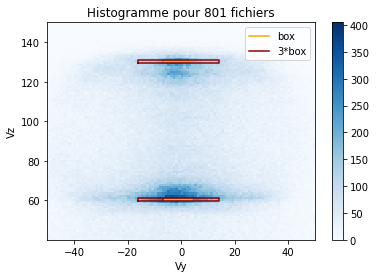

<Figure size 432x288 with 0 Axes>

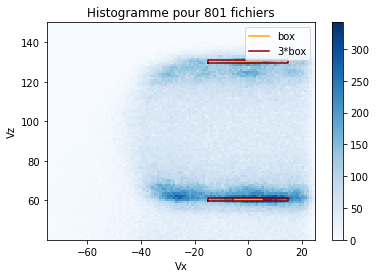

<Figure size 432x288 with 0 Axes>

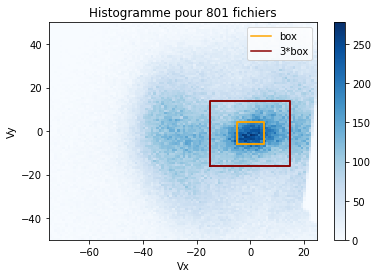

Gathering Vz2: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 125.01it/s]


Total dataframe is summed already
Computation is done.
##############################################################
#  Please chose your new Roi for   
####Plot_var = Vz1+Vz2  and Int_var = Vz1-Vz2
#################################################


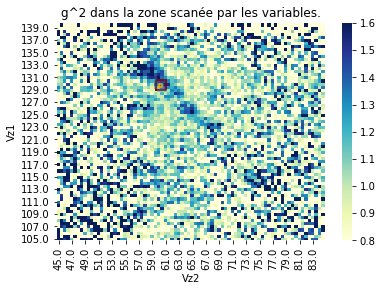

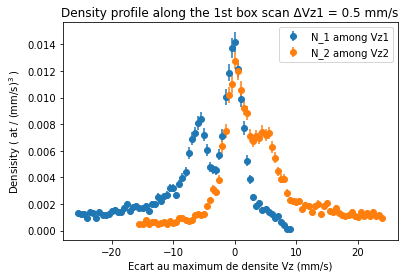

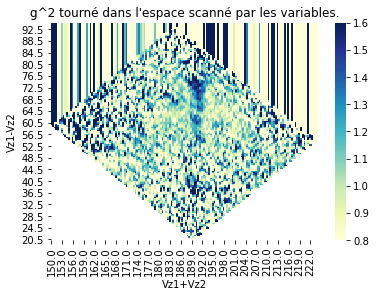

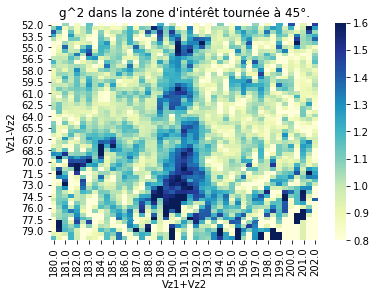

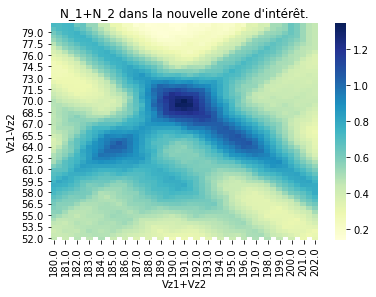

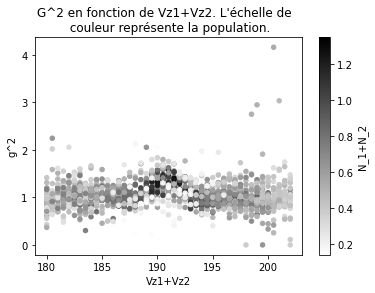

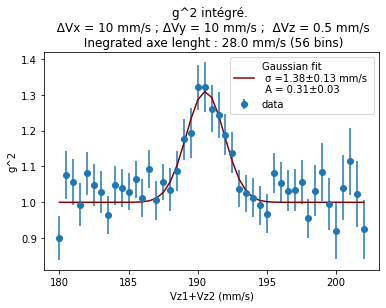

In [165]:
boxZsize = 0.5
boxXsize = 10
boxYsize = 10
Xposition = 0
Yposition = -1
boxes = {
    "1": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": 130},
    },
    "2": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": 60.6},
    },
}
ROI = {
    "Vz": {"max": 150, "min": 40},
    "Vy": {"min": -50, "max": 50},
    "Vx": {"max": 25, "min": -75},
}
boite = copy.deepcopy(boxes)
raman_kick = 42.5
# Variables pour rotation à 45° : la variable Int_var est celle le long de 
#laquelle nous allons intégrer et celle Plot_var sera celle en fonction de laquelle nous allons tracer.

Plot_var = "Vz1+Vz2" 
Int_var = "Vz1-Vz2" 

# variables d'affichage 
gmin_value =0.8
gmax_value=1.6

### First Plots 
corr = Correlation(data, n_cycles, ROI=ROI, boxes=boite, raman_kick=raman_kick)
plot_all_densities()

### Définition des variations des variables (ici Vz1 et Vz2 autour du premier pic)
corr.define_variable1(
    box="1", axe="Vz", type="position", name="Vz1", min=105, max=140, step=boxZsize
)
corr.define_variable2(
    box="2", axe="Vz", type="position", name="Vz2", min=45, max=85, step=boxZsize
)
#### Calcul
corr.compute_correlations()
### Seconds plots
show_second_serie_plots()

### Définition de la Région d'intérêt pour faire le fit
new_ROI = {Plot_var: {"min": 180, "max":202},
           Int_var: {"min": 52, "max": 80}}
df = corr.result.copy()
df = df[
    (
        (df[Int_var] >= new_ROI[Int_var]["min"])
        & (df[Int_var] <= new_ROI[Int_var]["max"])
        & (df[Plot_var] <= new_ROI[Plot_var]["max"])
        & (df[Plot_var] >= new_ROI[Plot_var]["min"])
    )
]
df["error on g^2 integrated"] = (df["g^2 error"] / df["g^2"]) ** 2
### Third plots
show_third_serie_of_plots()
show_g2_fitted_plot()

## $V_y$

Gathering Vy1:  24%|███████████████▊                                                  | 12/50 [00:00<00:00, 120.00it/s]

Data are loaded


Gathering Vy2: 100%|██████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 138.90it/s]


Total dataframe is summed already
Computation is done.
##############################################################
#  Please chose your new Roi for   
####Plot_var = Vy1-Vy2  and Int_var = Vy1+Vy2
#################################################


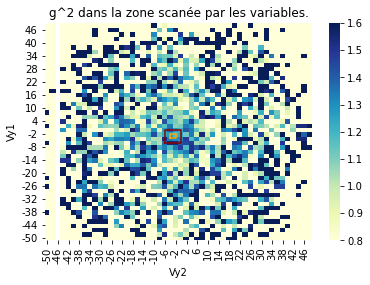

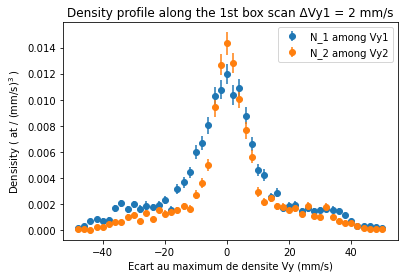

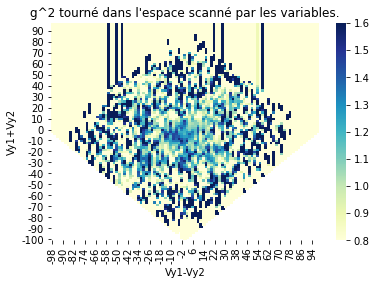

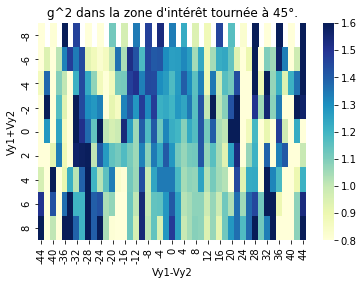

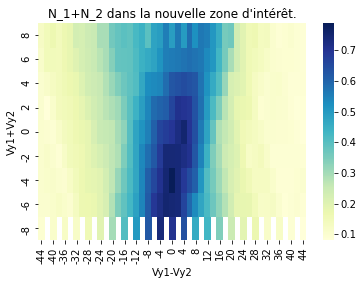

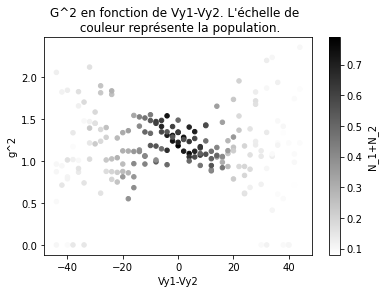

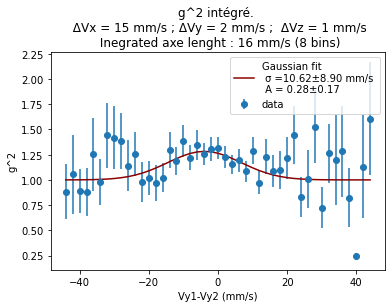

In [196]:
boxZsize = 1
boxXsize = 15
boxYsize = 2
Xposition = 0
Yposition = -1
Zpos1 = 60
Zpos2 = 130
boxes = {
    "1": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": Zpos1},
    },
    "2": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": Zpos2},
    },
}
ROI = {
    "Vz": {"max": 150, "min": 40},
    "Vy": {"min": -50, "max": 50},
    "Vx": {"max": 25, "min": -75},
}
boite = copy.deepcopy(boxes)
raman_kick = 42.5
# Variables pour rotation à 45° : la variable Int_var est celle le long de 
#laquelle nous allons intégrer et celle Plot_var sera celle en fonction de laquelle nous allons tracer.

Plot_var = "Vy1-Vy2" 
Int_var = "Vy1+Vy2" 

# variables d'affichage 
gmin_value =0.8
gmax_value=1.6

### First Plots 
corr = Correlation(data, n_cycles, ROI=ROI, boxes=boite, raman_kick=raman_kick, remove_shot_noise = False)
#plot_all_densities()

### Définition des variations des variables (ici Vz1 et Vz2 autour du premier pic)
corr.define_variable1(
    box="1", axe="Vy", type="position", name="Vy1", min=-50, max=50, step=boxYsize
)
corr.define_variable2(
    box="2", axe="Vy", type="position", name="Vy2", min=-50, max=50, step=boxYsize, 
)
#### Calcul
corr.compute_correlations()
### Seconds plots
show_second_serie_plots()

### Définition de la Région d'intérêt pour faire le fit
new_ROI = {Plot_var: {"min": -45, "max":45},
           Int_var: {"min": -8, "max": 8}}
df = corr.result.copy()
df = df[
    (
        (df[Int_var] >= new_ROI[Int_var]["min"])
        & (df[Int_var] <= new_ROI[Int_var]["max"])
        & (df[Plot_var] <= new_ROI[Plot_var]["max"])
        & (df[Plot_var] >= new_ROI[Plot_var]["min"])
    )
]
df["error on g^2 integrated"] = (df["g^2 error"] / df["g^2"]) ** 2
df["error on g^2 integrated absolute value"] = np.abs(df["g^2 error"] / df["g^2"])
df["number of elements"] = 1
### Third plots
show_third_serie_of_plots()
show_g2_fitted_plot()


## $V_x$

Gathering Vx2:   0%|                                                                            | 0/18 [00:00<?, ?it/s]

Data are loaded


Gathering Vx2: 100%|██████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 114.14it/s]


Total dataframe is summed already
Computation is done.
##############################################################
#  Please chose your new Roi for   
####Plot_var = Vx1-Vx2  and Int_var = Vx1+Vx2
#################################################


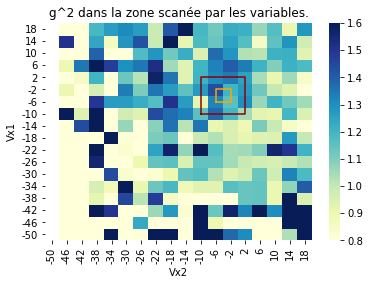

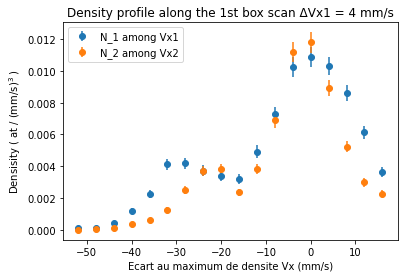

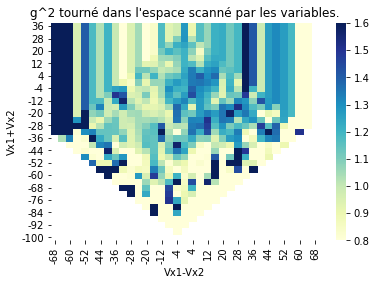

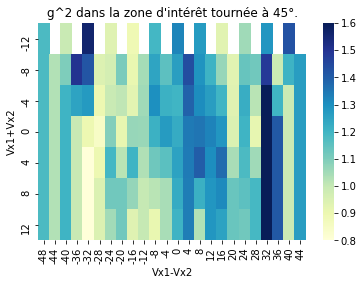

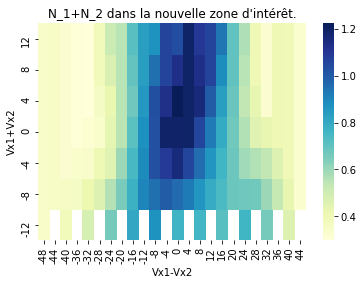

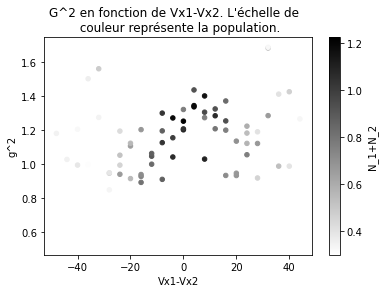

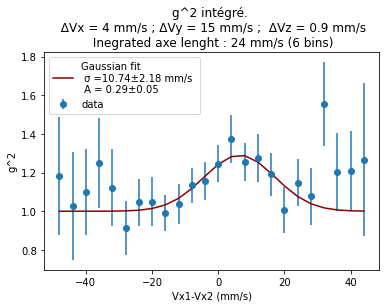

In [197]:
boxZsize = 0.9
boxXsize = 4
boxYsize = 15
Xposition = 0
Yposition = -1
Zpos1 = 60
Zpos2 = 130
boxes = {
    "1": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": Zpos1},
    },
    "2": {
        "Vx": {"size": boxXsize, "position": Xposition},
        "Vy": {"size": boxYsize, "position": Yposition},
        "Vz": {"size": boxZsize, "position": Zpos2},
    },
}
ROI = {
    "Vz": {"max": 150, "min": 40},
    "Vy": {"min": -50, "max": 50},
    "Vx": {"max": 25, "min": -75},
}
boite = copy.deepcopy(boxes)
raman_kick = 42.5
# Variables pour rotation à 45° : la variable Int_var est celle le long de 
#laquelle nous allons intégrer et celle Plot_var sera celle en fonction de laquelle nous allons tracer.

Plot_var = "Vx1-Vx2" 
Int_var = "Vx1+Vx2" 

# variables d'affichage 
gmin_value =0.8
gmax_value=1.6

### First Plots 
corr = Correlation(data, n_cycles, ROI=ROI, boxes=boite, raman_kick=raman_kick, remove_shot_noise = False)
#plot_all_densities()

### Définition des variations des variables (ici Vz1 et Vz2 autour du premier pic)
corr.define_variable1(
    box="1", axe="Vx", type="position", name="Vx1", min=-50, max=20, step=boxXsize
)
corr.define_variable2(
    box="2", axe="Vx", type="position", name="Vx2", min=-50, max=20, step=boxXsize, 
)
#### Calcul
corr.compute_correlations()
### Seconds plots
show_second_serie_plots()

### Définition de la Région d'intérêt pour faire le fit
new_ROI = {Plot_var: {"min": -55, "max":45},
           Int_var: {"min": -15, "max": 15}}
df = corr.result.copy()
df = df[
    (
        (df[Int_var] >= new_ROI[Int_var]["min"])
        & (df[Int_var] <= new_ROI[Int_var]["max"])
        & (df[Plot_var] <= new_ROI[Plot_var]["max"])
        & (df[Plot_var] >= new_ROI[Plot_var]["min"])
    )
]
df["error on g^2 integrated"] = (df["g^2 error"] / df["g^2"]) ** 2
df["error on g^2 integrated absolute value"] = np.abs(df["g^2 error"] / df["g^2"])
df["number of elements"] = 1
### Third plots
show_third_serie_of_plots()
show_g2_fitted_plot()
